In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from mcmctoolbox.functoolbox import flat

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

np.random.seed(1234)

In [2]:
# Load DataBase Locally
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-AnnulusGaussianMixture-test-AnnulusGaussianMixture")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

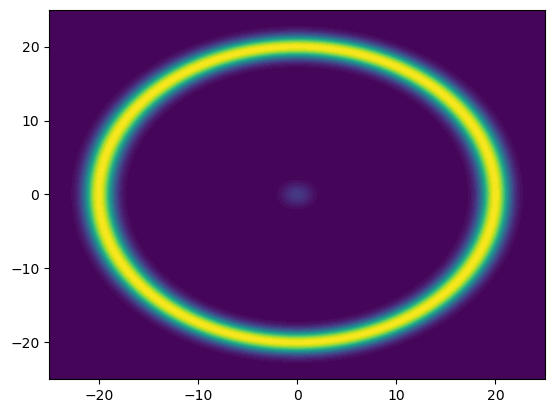

In [6]:
num = 1000
x = np.linspace(-25, 25, num)
y = np.linspace(-25, 25, num)
X, Y = np.meshgrid(x, y)

Z = np.zeros((num, num))

for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = np.exp(log_p(np.array([x[i], y[j]])))

plt.contourf(X, Y, Z.T, 50, cmap='viridis')
plt.savefig('Pic/AnnulusGaussianMixture_true.png', dpi=300)

In [ ]:
def annulus_sample(n_samples, r0=20, sigma=1):

    def reject_sample(n_samples):
        """
        Generates non-negative independent samples.
        """
        r = np.ones(n_samples) * -1
        f = r < 0
        while np.any(f):
            r = np.random.normal(r0, sigma, size=np.sum(f))
            f = r < 0
        return r

    n_samples = int(n_samples)

    # First sample values of r
    r = reject_sample(n_samples)

    # uniformly sample X s.t. their normed distance is r0
    X_norm = np.random.normal(size=(n_samples, 2))
    lambda_x = np.sqrt(np.sum(X_norm**2, axis=1))
    x_unit = [r[i] * X_norm[i] / y for i, y in enumerate(lambda_x)]

    return np.array(x_unit)

In [ ]:
gs = np.zeros((10_000, 2))

for i in range(10_000):
    if np.random.binomial(1, 0.3, size=1):
        gs[i, :] = multivariate_normal.rvs(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1)
    else:
        gs[i, :] = annulus_sample(n_samples=1, r0=10, sigma=1)

In [ ]:
np.savetxt("Data/AnnulusGaussianMixture.csv", gs, delimiter=",")